# 🔮 Optimisation du Clustering des Cours

Ce notebook démontre comment améliorer le clustering des cours pour obtenir des thématiques plus distinctes et éviter la redondance des catégories comme "Machine Learning" dans tous les groupes.

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
df = pd.read_csv('../processed_data/final_courses_shuffled.csv')
print(f"Nombre de cours : {len(df)}")

Nombre de cours : 1855


## 1. Problématique

Actuellement, le clustering utilise des mots très fréquents comme "Machine", "Learning", "Course" qui dominent les vecteurs TF-IDF. Pour obtenir de meilleurs résultats, nous devons :
1. Ajouter des **mots vides (stop words)** personnalisés.
2. Donner plus de poids à la **catégorie** par rapport au titre.
3. Optimiser le nombre de clusters ($k$).

In [16]:
# 2. Amélioration de la pondération
# On répète la catégorie 5 fois au lieu de 3 pour bien forcer le regroupement thématique
df['weighted_features'] = df.apply(
    lambda x: (str(x['category']) + ' ') * 3 + str(x['title']),
    axis=1
)

# 3. Vectorisation avec les nouveaux paramètres
tfidf = TfidfVectorizer(
    max_features=2000,
    ngram_range=(1, 2) # Pour capturer "Data Science", "Web Dev", etc.
)
tfidf_matrix = tfidf.fit_transform(df['weighted_features'])

# 4. Relancer le K-means (K=12 ou 15 peut donner de meilleurs résultats ici)
k_optimal = 14

kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

# 5. Analyse des clusters raffinés
for i in range(k_optimal):
    cluster_data = df[df['cluster'] == i]
    top_cats = cluster_data['category'].value_counts().head().index.tolist()
    print(f"\n🔵 Cluster {i} ({len(cluster_data)} cours) :")
    print(f"   Top Catégories: {', '.join(top_cats)}")
    print(f"   Exemples: {', '.join(cluster_data['title'].head().tolist())}")


🔵 Cluster 0 (165 cours) :
   Top Catégories: Health, Health and Fitness
   Exemples: Running Mechanics and Injury Prevention Strategies, Uso de la IA para la prevención de lesiones y recuperación, Healthcare Career Explorer: Certified Nursing Assistant, Theoretical Bases of Health and Injury Management , Sports Nutrition and Training: Innovation Assets

🔵 Cluster 1 (71 cours) :
   Top Catégories: Computer Science
   Exemples: Web Dev: Optimization, Server Processing, and JavaScript, Full Stack Web Development Build a Computer Science Portal, Computational Thinking for Problem Solving, Discrete Mathematics for Computer Science and Engineering, Computer Science:  Algorithms, Theory, and Machines

🔵 Cluster 2 (243 cours) :
   Top Catégories: Machine Learning, Language Learning
   Exemples: Mathematics for Machine Learning, Learn Mandarin Chinese: Intermediate, Machine Learning & Deep Learning in Python & R, Everything You Need to Know About AI in 2026, Learn English: Beginning Grammar

🔵

## Visualisation PCA
Nous projetons les données en 2D pour voir la séparation.

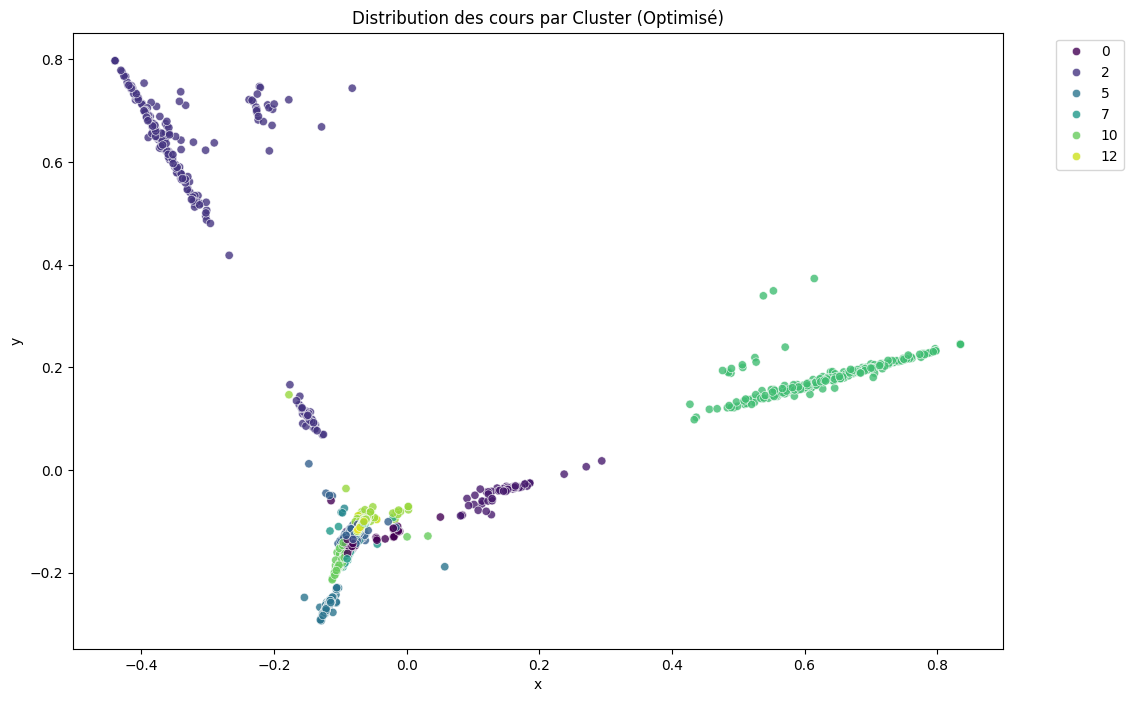

In [17]:
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(tfidf_matrix.toarray())
df['x'], df['y'] = coords[:, 0], coords[:, 1]

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='x', y='y', hue='cluster', palette='viridis', alpha=0.8)
plt.title('Distribution des cours par Cluster (Optimisé)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

C:\Users\LEGION 5\AppData\Local\Temp\ipykernel_25524\1978692493.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


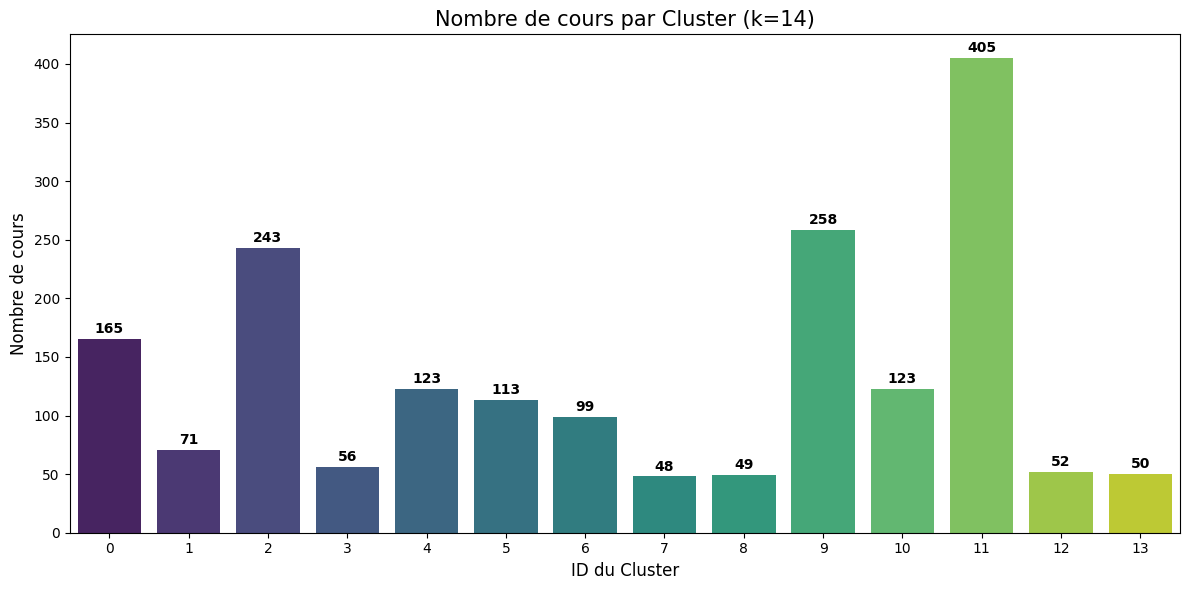

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul du nombre de cours par cluster
cluster_counts = df['cluster'].value_counts().sort_index()

# Création du Bar Chart
plt.figure(figsize=(12, 6))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')

# Ajout des labels et titre
plt.title('Nombre de cours par Cluster (k=14)', fontsize=15)
plt.xlabel('ID du Cluster', fontsize=12)
plt.ylabel('Nombre de cours', fontsize=12)
plt.xticks(range(k_optimal))

# Affichage des valeurs au-dessus des barres
for i, count in enumerate(cluster_counts):
    plt.text(i, count + 5, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

✅ Graphique sauvegardé: cluster_categories_visualization.png


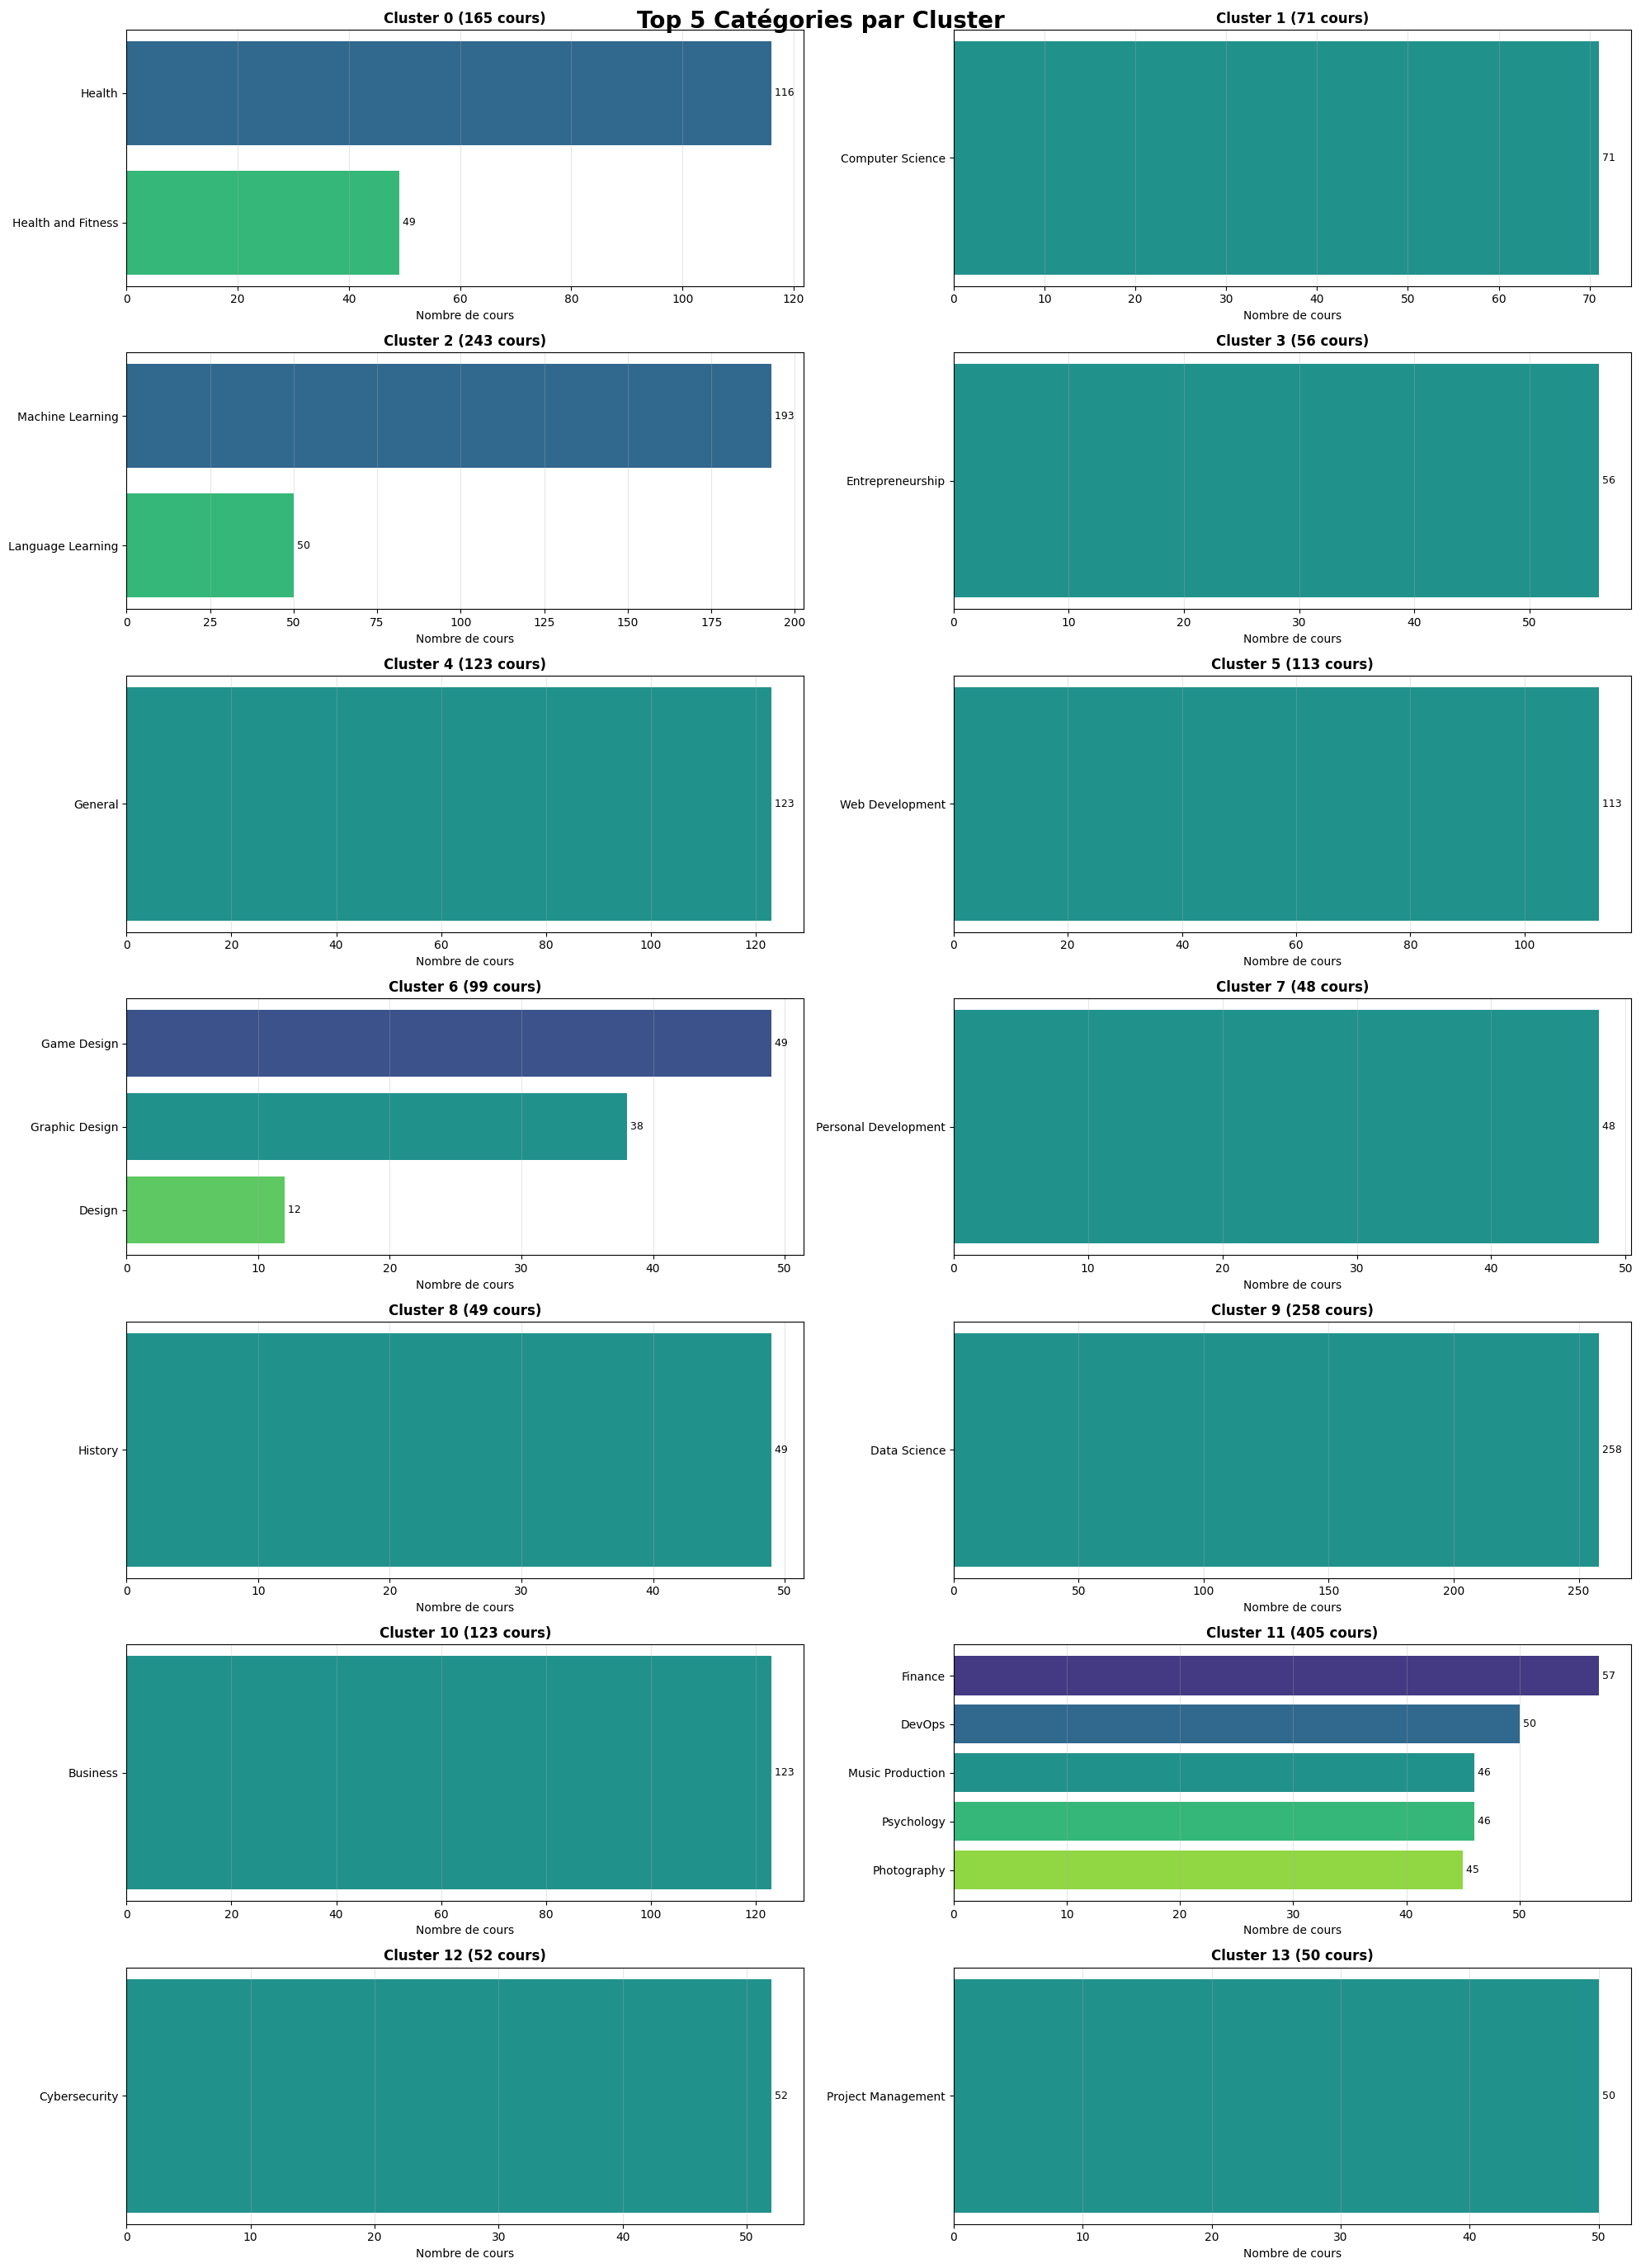

In [19]:
# afficher les top 5 categories de chaque cluster 

# Créer une figure avec des sous-graphiques pour chaque cluster
fig, axes = plt.subplots(7, 2, figsize=(20, 28))
fig.suptitle('Top 5 Catégories par Cluster', fontsize=20, fontweight='bold')

# Aplatir le tableau d'axes pour faciliter l'itération
axes = axes.flatten()

# Pour chaque cluster
for i in range(k_optimal):
    cluster_data = df[df['cluster'] == i]
    
    # Obtenir les top 5 catégories
    top_categories = cluster_data['category'].value_counts().head(5)
    
    # Créer le graphique
    ax = axes[i]
    colors = sns.color_palette('viridis', len(top_categories))
    bars = ax.barh(range(len(top_categories)), top_categories.values, color=colors)
    
    # Configurer les labels
    ax.set_yticks(range(len(top_categories)))
    ax.set_yticklabels(top_categories.index, fontsize=10)
    ax.set_xlabel('Nombre de cours', fontsize=10)
    ax.set_title(f'Cluster {i} ({len(cluster_data)} cours)', fontsize=12, fontweight='bold')
    
    # Ajouter les valeurs sur les barres
    for j, (bar, value) in enumerate(zip(bars, top_categories.values)):
        ax.text(value, j, f' {value}', va='center', fontsize=9)
    
    # Inverser l'ordre pour avoir le top en haut
    ax.invert_yaxis()
    
    # Grille pour faciliter la lecture
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('cluster_categories_visualization.png', dpi=300, bbox_inches='tight')
print("✅ Graphique sauvegardé: cluster_categories_visualization.png")
plt.show()

In [20]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

print("Calcul des métriques d'évaluation en cours...")

# Note: Le calcul du Silhouette Score peut être long sur de gros datasets
# On utilise la matrice TF-IDF dense pour les deux dernières métriques
tfidf_dense = tfidf_matrix.toarray()

sil_score = silhouette_score(tfidf_matrix, df['cluster'])
db_score = davies_bouldin_score(tfidf_dense, df['cluster'])
ch_score = calinski_harabasz_score(tfidf_dense, df['cluster'])

print(f"\n--- Métriques d'évaluation du Clustering (k={k_optimal}) ---")
print(f"Silhouette Score ( -1 à 1, plus haut est mieux ) : {sil_score:.4f}")
print(f"Davies-Bouldin Index ( plus bas est mieux )      : {db_score:.4f}")
print(f"Calinski-Harabasz Index ( plus haut est mieux )  : {ch_score:.4f}")

Calcul des métriques d'évaluation en cours...

--- Métriques d'évaluation du Clustering (k=14) ---
Silhouette Score ( -1 à 1, plus haut est mieux ) : 0.2798
Davies-Bouldin Index ( plus bas est mieux )      : 1.9219
Calinski-Harabasz Index ( plus haut est mieux )  : 112.3882
